# Import Relevant Packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math

import plotly.graph_objects as go
import us  # Import the us library

from causallearn.search.ConstraintBased.PC import pc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.preprocessing import StandardScaler

# Load the Data

In [2]:
shopper_intent = pd.read_csv("data/online_shoppers_intention.csv")
shopper_intent

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


In [3]:
shopper_intent.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [4]:
shopper_intent.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [5]:
shopper_intent.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
shopper_intent['Revenue'] = shopper_intent['Revenue'].astype(int)
shopper_intent['Weekend'] = shopper_intent['Weekend'].astype(int)

# Exploratory Data Analysis

In [7]:
shopper_intent['SpecialDay'].max()

1.0

Let's try to see if we can find any relations between the variables and our target variable, "Revenue"

In [8]:
# Define variable types
discrete_vars = ["Month", "Browser", "Region", "TrafficType", "VisitorType", "Weekend"]
continuous_vars = [
    "Administrative", "Administrative_Duration", "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues", "SpecialDay"
]

# Function to create subplots grid
def create_grid_plot(variables, plot_type, title, rows, cols, figsize, data):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    fig.suptitle(title, fontsize=16, y=1.02)
    axes = axes.flatten()

    for i, var in enumerate(variables):
        ax = axes[i]
        if plot_type == "continuous":
            sns.boxplot(data=data, x="Revenue", y=var, ax=ax)
            ax.set_title(f"{var} vs Revenue")
            ax.set_ylabel(var)
            ax.set_xlabel("Revenue")
        elif plot_type == "discrete":
            if var == "Month":
                sns.countplot(data=data, x=var, hue="Revenue", ax=ax, order=[
                    "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
                ])
            else:
                sns.countplot(data=data, x=var, hue="Revenue", ax=ax)
            ax.set_title(f"{var} vs Revenue")
            ax.set_ylabel("Count")
            ax.set_xlabel(var)

    # Hide any unused axes
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Continuous Variables Plot

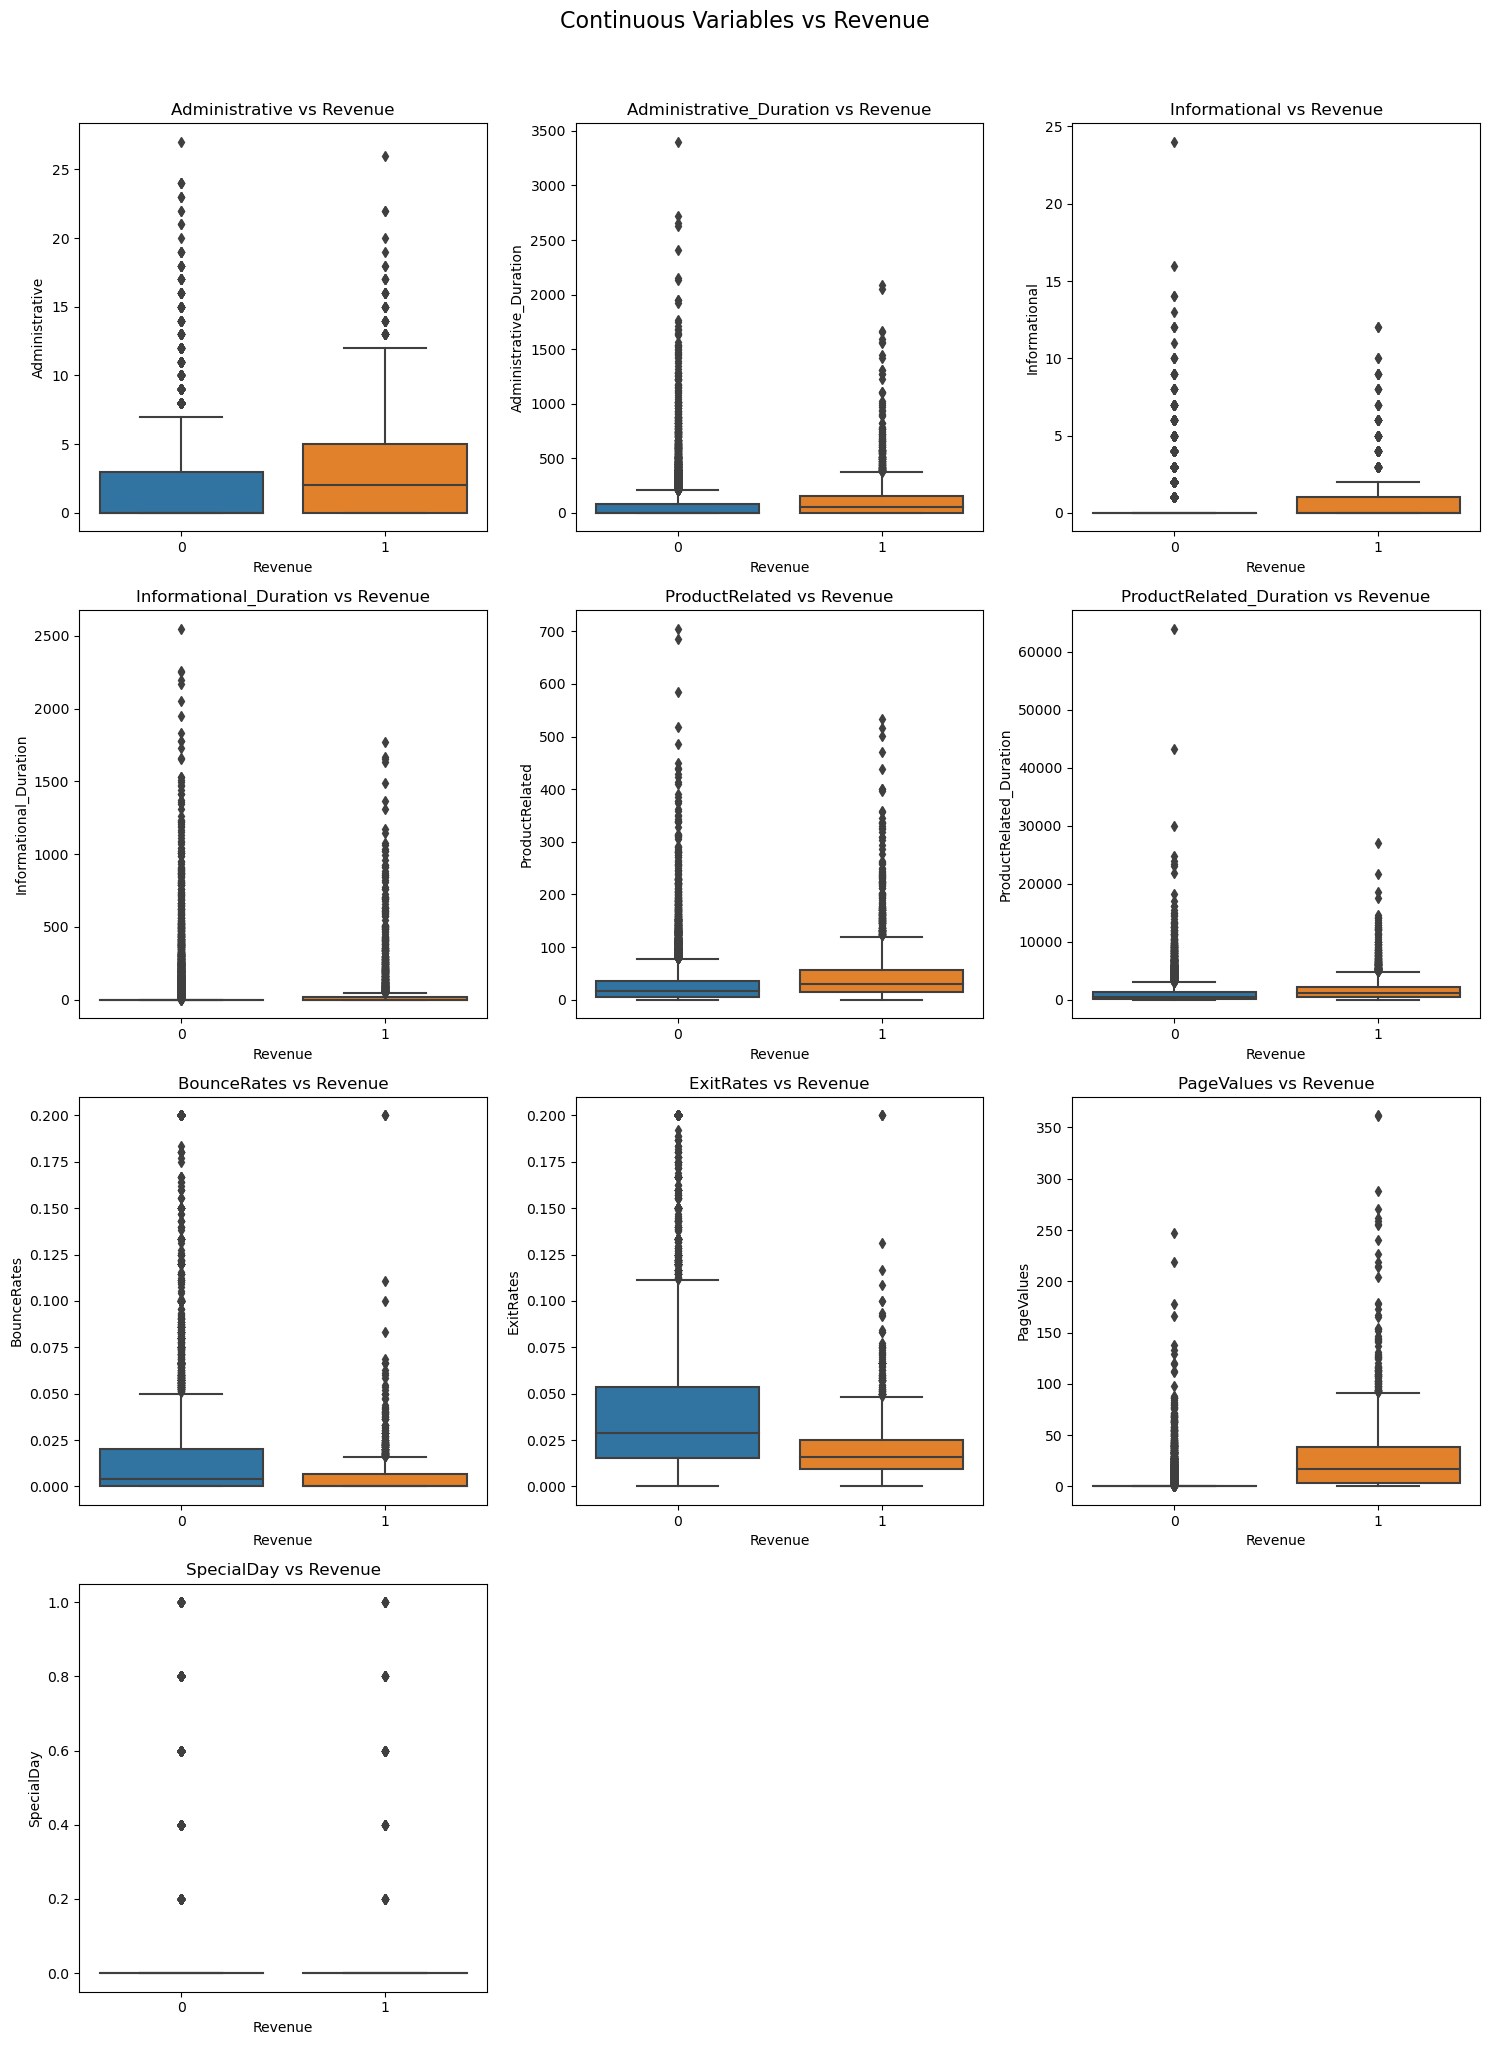

In [9]:
num_continuous = len(continuous_vars)
rows_continuous = math.ceil(num_continuous / 3)
create_grid_plot(
    variables=continuous_vars,
    plot_type="continuous",
    title="Continuous Variables vs Revenue",
    rows=rows_continuous,
    cols=3,
    figsize=(15, 5 * rows_continuous),
    data=shopper_intent
)



## Discrete Variables Plot

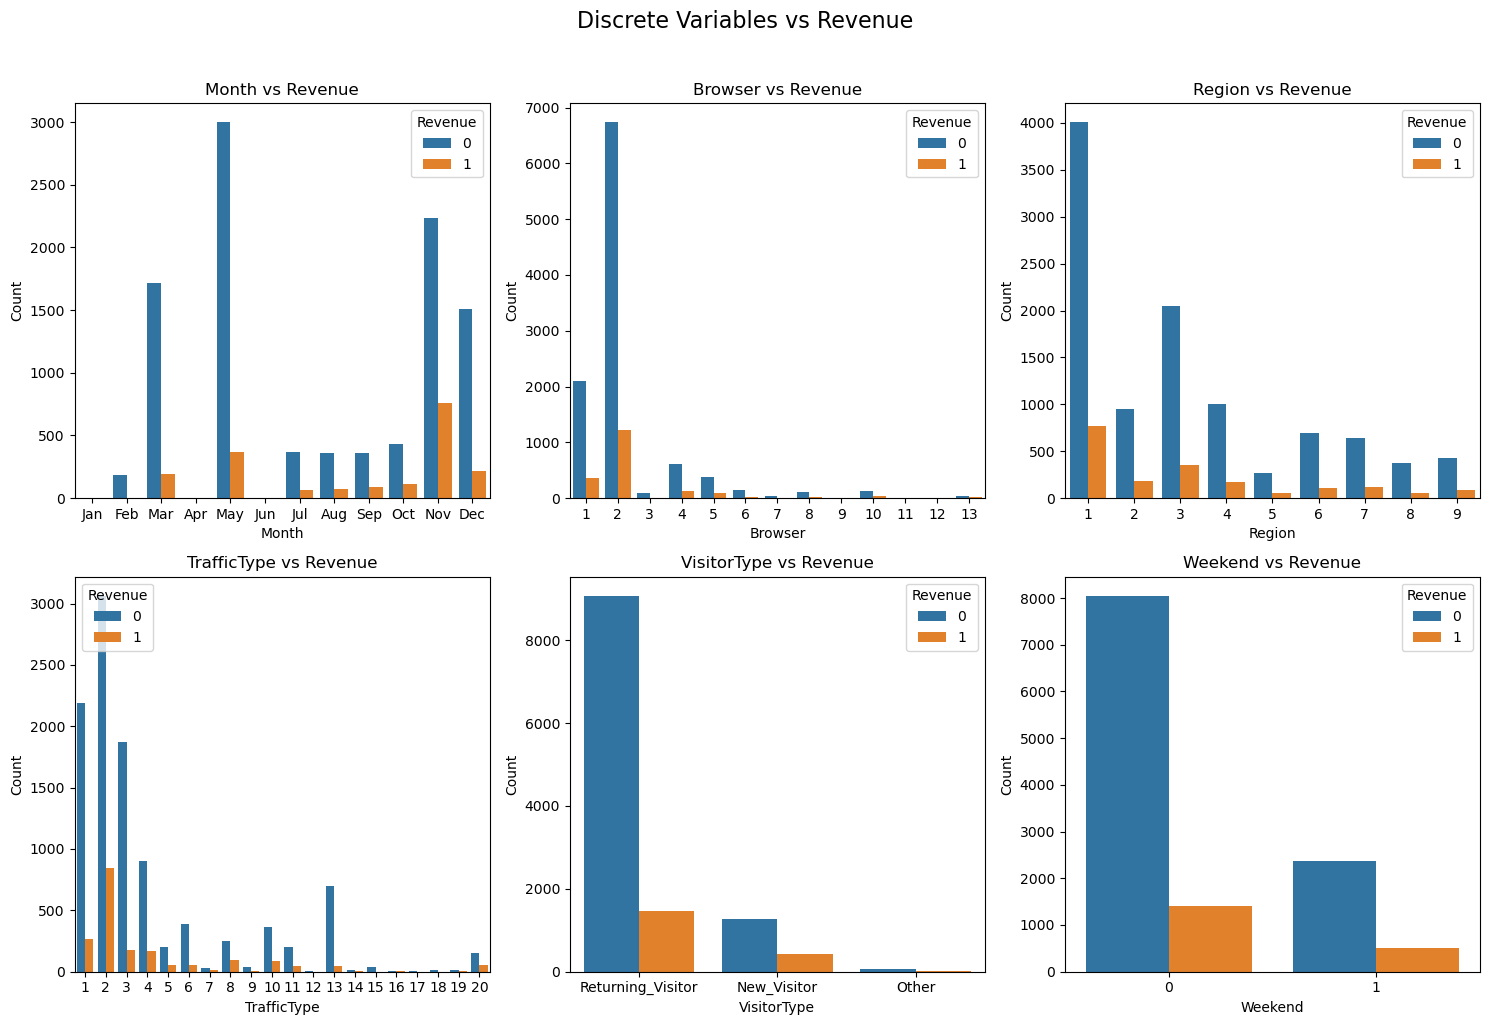

In [10]:
num_discrete = len(discrete_vars)
rows_discrete = math.ceil(num_discrete / 3)
create_grid_plot(
    variables=discrete_vars,
    plot_type="discrete",
    title="Discrete Variables vs Revenue",
    rows=rows_discrete,
    cols=3,
    figsize=(15, 5 * rows_discrete),
    data=shopper_intent
)

In [13]:
data_encoded = pd.get_dummies(shopper_intent, drop_first=True)
data_encoded

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,...,0,0,0,0,0,0,0,0,0,1
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,1
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,1
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,1


In [20]:
# all the column names
columns_to_use = [
    'SpecialDay', 'Revenue', 'BounceRates', 'ExitRates', 'PageValues',
    'Weekend', 'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration', 'ProductRelated',
    'ProductRelated_Duration', 'OperatingSystems', 'Browser', 'Region',
    'TrafficType', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
    'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
    'VisitorType_Other', 'VisitorType_Returning_Visitor'
]

In [14]:
data_frame = data_encoded
# Step 1: Convert DataFrame to NumPy array>
data_array = data_frame.to_numpy()

# Step 2: Apply the PC algorithm to discover the causal graph
alpha = 0.05  # Significance level
pc_graph = pc(data_array, alpha)

# Step 3: Create labels for nodes based on DataFrame columns
node_labels = {i: col for i, col in enumerate(data_encoded.columns)}

# Step 4: Extract edges from the pc_graph and create a NetworkX directed graph
G = nx.DiGraph()
G.add_nodes_from(node_labels.keys())

# Add edges based on the adjacency matrix
for i in range(len(pc_graph.G.graph)):
    for j in range(len(pc_graph.G.graph)):
        if pc_graph.G.graph[i, j] != 0:  # Check for an edge
            if pc_graph.G.graph[j, i] == 1 and pc_graph.G.graph[i, j] == -1:
                # Case: i -> j
                G.add_edge(i, j, edge_type='directed')
            elif pc_graph.G.graph[j, i] == -1 and pc_graph.G.graph[i, j] == -1:
                # Case: i -- j (undirected)
                G.add_edge(i, j, edge_type='undirected')
            elif pc_graph.G.graph[j, i] == 1 and pc_graph.G.graph[i, j] == 1:
                # Case: i <-> j (bidirectional)
                G.add_edge(i, j, edge_type='bidirectional')

  0%|          | 0/27 [00:00<?, ?it/s]

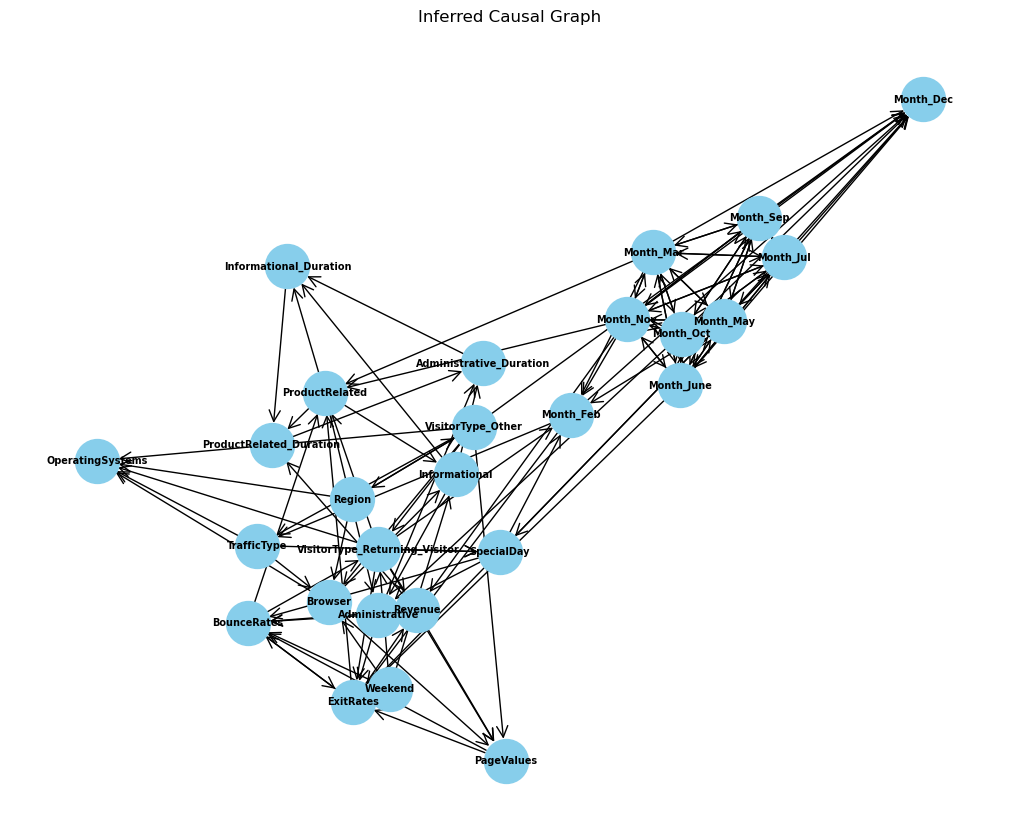

In [15]:
# Step 5: Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Increase k for more space between nodes
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1000, node_color="skyblue", font_size=7, font_weight="bold", arrowstyle="->", arrowsize=20)
plt.title("Inferred Causal Graph")
plt.show()

## Let's find the nodes only related to Revenue

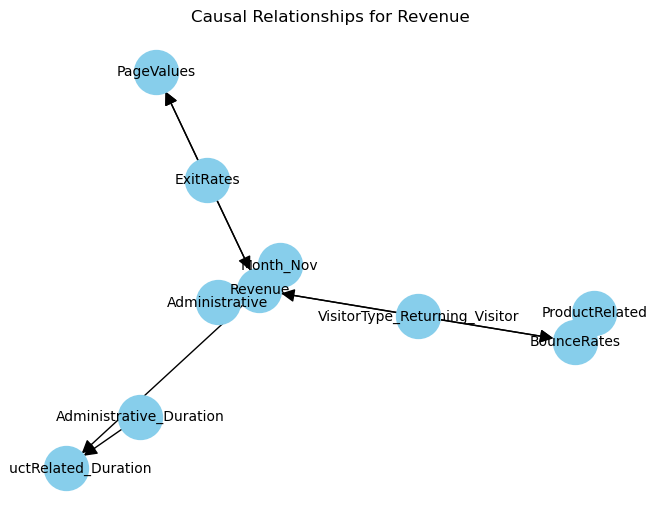

Parents of Revenue: ['Administrative', 'VisitorType_Returning_Visitor', 'Month_Nov', 'ExitRates']
Children of Revenue: ['PageValues', 'ProductRelated_Duration', 'BounceRates']
Spouses of Revenue: ['Administrative_Duration', 'VisitorType_Returning_Visitor', 'ProductRelated', 'ExitRates']


In [32]:
# Find the index of the "Revenue" node
revenue_index = list(data_encoded.columns).index("Revenue")

# Get the adjacency matrix from the PC graph
graph_matrix = pc_graph.G.graph  # Assuming this is a NumPy array or similar

# Initialize sets for storing relationships
parents = set()
children = set()
spouses = set()
edges = []  # Store edges for graph visualization

# First Loop: Find direct relationships (parents and children)
for j in range(graph_matrix.shape[0]):
    if j == revenue_index:
        continue  # Skip self-loops

    if graph_matrix[j, revenue_index] == 1 and graph_matrix[revenue_index, j] == -1:
        # Directed edge (Revenue → j): j is a child
        children.add(j)
        edges.append((revenue_index, j))
    elif graph_matrix[revenue_index, j] == 1 and graph_matrix[j, revenue_index] == -1:
        # Directed edge (j → Revenue): j is a parent
        parents.add(j)
        edges.append((j, revenue_index))
    elif graph_matrix[revenue_index, j] == 1 and graph_matrix[j, revenue_index] == -1:
        #Bidirected edge
        parents.add(j)
        children.add(j)
        edges.append((j, revenue_index))
        edges.append((revenue_index, j))

# Second Loop: Identify spouses by checking for shared children
for child in children:
    for j in range(graph_matrix.shape[0]):
        if j == revenue_index or j in children:
            continue  # Skip self-loops and already identified children

        if graph_matrix[j, child] == 1 and graph_matrix[child, j] == -1:
            # Directed edge (child → j): j shares a child with Revenue
            spouses.add(j)
            edges.append((j, child))  # Add directed edge from spouse to the child

# Create a subgraph with only the related nodes (parents, children, spouses)
related_nodes = {revenue_index} | parents | children | spouses

# Create a directed graph
subgraph = nx.DiGraph()
subgraph.add_nodes_from(related_nodes)
subgraph.add_edges_from(edges)

# Map node indices to column names for readability
node_labels = list(data_encoded.columns)
subgraph = nx.relabel_nodes(subgraph, {i: node_labels[i] for i in related_nodes})

# Draw the subgraph
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=1000, font_size=10, node_color="skyblue", arrowsize=20)
plt.title("Causal Relationships for Revenue")
plt.show()

# Print the results
parents = [node_labels[i] for i in parents]
children = [node_labels[i] for i in children]
spouses = [node_labels[i] for i in spouses]
print("Parents of Revenue:", parents)
print("Children of Revenue:", children)
print("Spouses of Revenue:", spouses)

## Let's see the graphs of only the variables that are related to Revenue

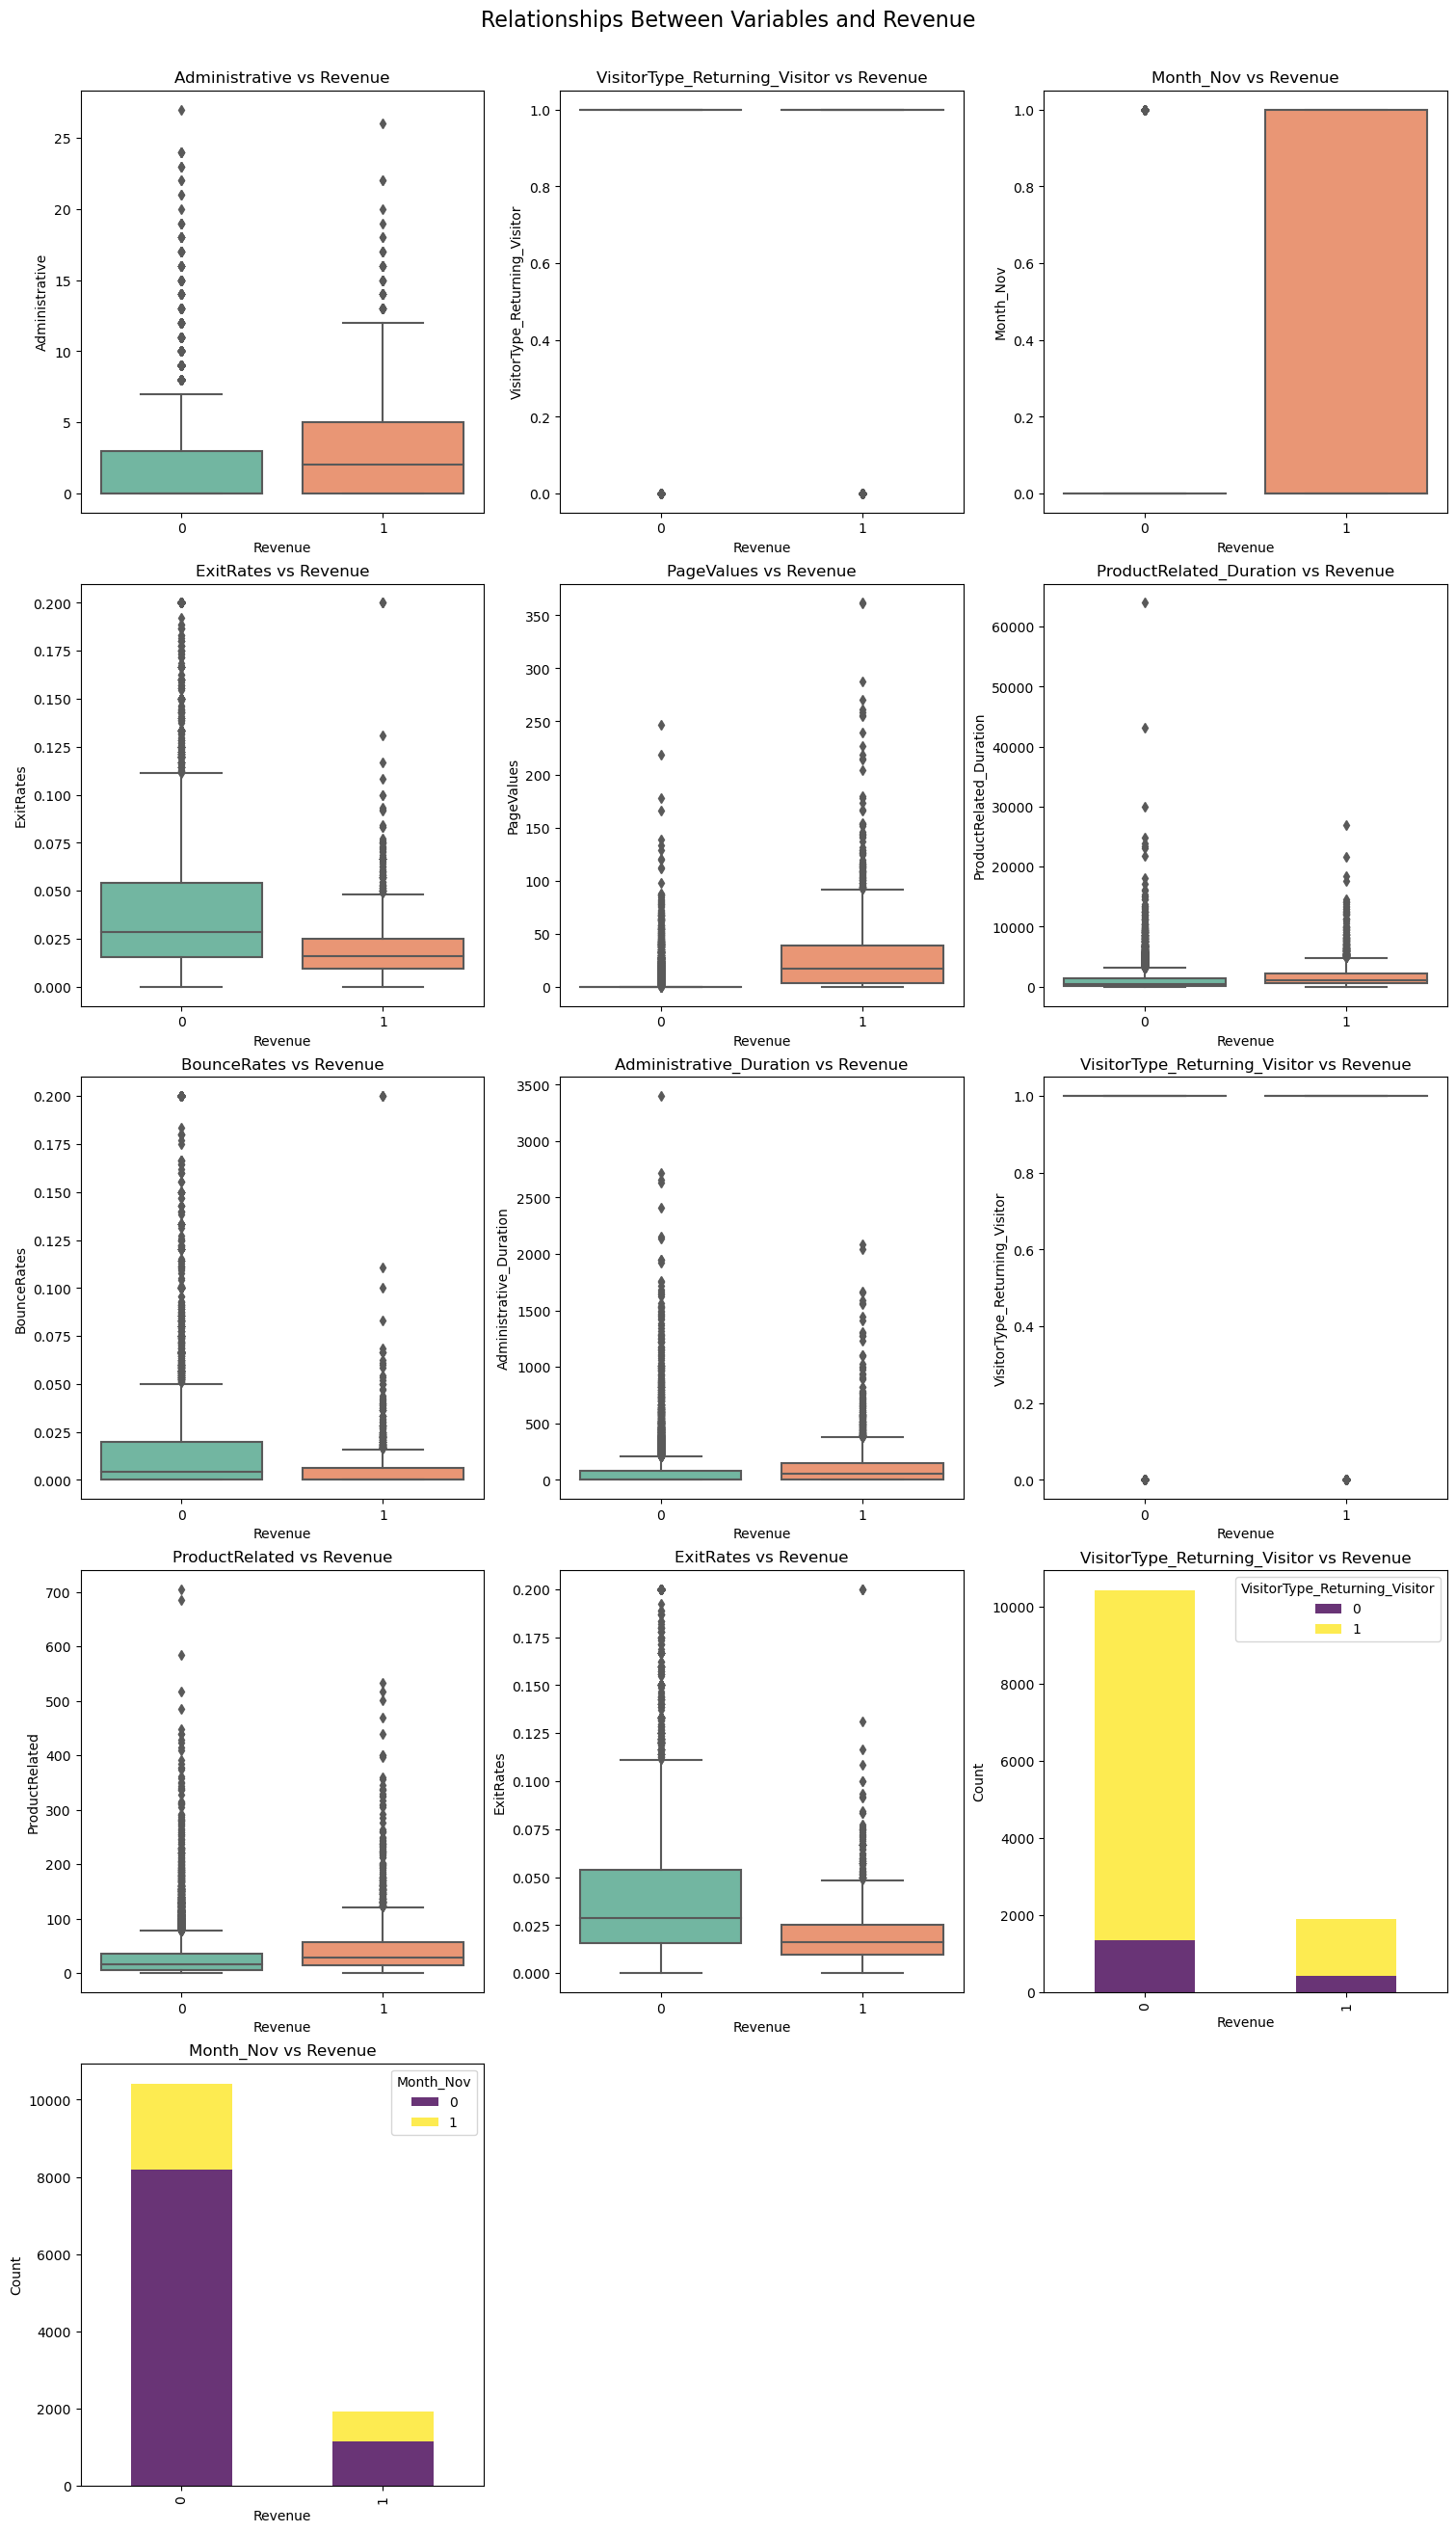

In [48]:
# Define children, spouses, and discrete variable
# Continuous variables
continuous_vars = [var for var in parents + children + spouses if var != "VisitorType_Returning_Visitor" or var!= "Month_Nov"]

# Create a figure with subplots
num_vars = len(parents) + len(children) + len(spouses)
cols = 3  # Number of columns in the grid
rows = 6  # Ceiling division
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot continuous variables
for i, var in enumerate(continuous_vars):
    sns.boxplot(x="Revenue", y=var, data=data_encoded, ax=axes[i], palette="Set2")
    axes[i].set_title(f"{var} vs Revenue")
    axes[i].set_xlabel("Revenue")
    axes[i].set_ylabel(var)

    
# Plot discrete variables
discrete_vars = ["VisitorType_Returning_Visitor", "Month_Nov"]
for i, var in enumerate(discrete_vars):
    # Group data to calculate counts
    discrete_var_counts = data_encoded.groupby(["Revenue", var]).size().unstack()

    # Plot stacked bar chart
    discrete_var_counts.plot(
        kind="bar", 
        stacked=True, 
        colormap="viridis", 
        alpha=0.8,
        ax=axes[len(continuous_vars)+i]
    )

    axes[len(continuous_vars)+i].set_title(f"{var} vs Revenue")
    axes[len(continuous_vars)+i].set_xlabel("Revenue")
    axes[len(continuous_vars)+i].set_ylabel(f"Count")

# Hide any remaining empty subplots
for j in range(len(continuous_vars) + len(discrete_vars), len(axes)):
    axes[j].set_visible(False)

# Show the figure
plt.suptitle("Relationships Between Variables and Revenue", fontsize=16, y=1.02)
plt.show()


In [29]:
# Define columns for parents, children, and spouses

selected_features = parents +children + spouses

# Prepare the data
X = data_encoded.drop(columns=["Revenue"])  # All features except target
y = data_encoded["Revenue"]                # Target variable

# Scale continuous features for logistic regression
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=40)

# Model 1: Logistic Regression with all variables
model_all = LogisticRegression(max_iter=1000, random_state=42)
model_all.fit(X_train, y_train)

# Model 2: Logistic Regression with selected variables
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model_selected = LogisticRegression(max_iter=1000, random_state=42)
model_selected.fit(X_train_selected, y_train)

# Predictions
y_pred_all = model_all.predict(X_test)
y_pred_selected = model_selected.predict(X_test_selected)

# Metrics
def evaluate_model(y_true, y_pred, y_prob=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
    }
    if y_prob is not None:
        metrics["AUC-ROC"] = roc_auc_score(y_true, y_prob)
    return metrics

# Evaluate both models
y_prob_all = model_all.predict_proba(X_test)[:, 1]
y_prob_selected = model_selected.predict_proba(X_test_selected)[:, 1]

metrics_all = evaluate_model(y_test, y_pred_all, y_prob_all)
metrics_selected = evaluate_model(y_test, y_pred_selected, y_prob_selected)

# Display results
print("Model with All Variables")
for metric, value in metrics_all.items():
    print(f"{metric}: {value:.4f}")

print("\nModel with Selected Variables")
for metric, value in metrics_selected.items():
    print(f"{metric}: {value:.4f}")

# Classification reports
print("\nClassification Report (All Variables):\n", classification_report(y_test, y_pred_all))
print("\nClassification Report (Selected Variables):\n", classification_report(y_test, y_pred_selected))


Model with All Variables
Accuracy: 0.8754
Precision: 0.6947
Recall: 0.3462
F1 Score: 0.4621
AUC-ROC: 0.8767

Model with Selected Variables
Accuracy: 0.8786
Precision: 0.7085
Recall: 0.3654
F1 Score: 0.4821
AUC-ROC: 0.8740

Classification Report (All Variables):
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      3127
           1       0.69      0.35      0.46       572

    accuracy                           0.88      3699
   macro avg       0.79      0.66      0.70      3699
weighted avg       0.86      0.88      0.86      3699


Classification Report (Selected Variables):
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      3127
           1       0.71      0.37      0.48       572

    accuracy                           0.88      3699
   macro avg       0.80      0.67      0.71      3699
weighted avg       0.86      0.88      0.86      3699

